# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
from ipywidgets import interact, interactive, fixed, interact_manual
%matplotlib inline

## Read in an Image

In [ ]:
#reading in an image
image = mpimg.imread('test_images/challenge.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_img_ROI(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image in place (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def draw_lane_lines(img, lines, color=[255, 0, 0], thickness=10, slope_threshold_px=0.02, y_min=0, y_max=100):
    """
    Draws and connects lines with a similar slope. It aggregates lines which slope is within +[0,slope_threshold_px]
    from the current slope.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image in place (mutates the image).

    """
    # Clean up data
    y_min = int(y_min)
    y_max = int(y_max)
    lines = np.squeeze(lines)  # make proper matrix out of lines ndarray

    # check if lines is not empty (could indicate a blank frame) AND there is strictly more than 1 line detected
    if(lines.item(0) != None and np.size(lines.shape) > 1):

        # computing each of the lines slopes
        slopes = (lines[:, 3] - lines[:, 1]) / (lines[:, 2] - lines[:, 0])  # deltaY / deltaX

        # sort lines by slope - this is mandatory for the following to work
        lines_sorted = lines[slopes.argsort()]
        slopes.sort()

        origins = lines_sorted[:, 3] - np.multiply(lines_sorted[:, 2],
                                                   slopes)  # element wise mult to get y2 - m.x2, with m = slope

        # Right and left lanes to be detected - format will be x1, y1, x2, y2, slope, origin
        left_lane = []
        right_lane = []
        aggregated_lines = []

        search_for_lines = True
        next_slope_min_index = 0
        # current slope to be aggregated is pointed to by the indexes of the items lower than (min + threshold)
        next_slope_min_indexes = np.where(slopes < slopes[next_slope_min_index] + slope_threshold_px)
        last_slope = 0

        while (search_for_lines):

            # find similar lines according to slope threshold
            match_indices = (slopes >= slopes[next_slope_min_index]) & (
                    slopes < slopes[next_slope_min_index] + slope_threshold_px)

            av_slope = np.average(slopes[match_indices])
            av_origin = np.average(origins[match_indices])

            # solving line eq to find the x's
            # horizontal lines
            if(av_slope == 0):
                x1 = int(np.average(lines_sorted[match_indices, 0]))
                x2 = int(np.average(lines_sorted[match_indices, 2]))
                y1 = np.min(lines_sorted[match_indices, 1])
                y2 = y1 # arbitrary - they area almost equal anyway...
            elif(av_slope == np.inf or av_slope == -np.inf):
                x1 = 0
                x2 = 2000 # any big value
                y1 = np.average(lines_sorted[match_indices, 1])
                y2 = np.average(lines_sorted[match_indices, 3])
            else: # normal case: right and left lanes detected
                x1 = int((y_min - av_origin) / av_slope)
                x2 = int((y_max - av_origin) / av_slope)
                y1 = y_min
                y2 = y_max

            # draw new line and store
            aggregated_lines.append([x1, y1, x2, y2, av_slope, av_origin])

            if (next_slope_min_indexes[0][-1] == np.size(slopes) - 1):  # the line we reached is the last one to be aggregated
                search_for_lines = False  # this will break the loop after drawing this last line
            else:
                # move index pointing to the new min in the slope array
                next_slope_min_index = next_slope_min_indexes[0][-1] + 1
                next_slope_min_indexes = np.where((slopes >= slopes[next_slope_min_index]) & (
                        slopes < slopes[next_slope_min_index] + slope_threshold_px))
                last_slope = av_slope # storing last aggreg line slope to detect sign change

        # finding the left and right lane: as the slopes were sorted, and as the closest lanes to the POV have max. slope, we can simply choose the first line accumulated (most negative slope) and the last one (most positive) as the left / right lanes, resp.
        left_lane = aggregated_lines[0]
        right_lane = aggregated_lines[-1]
        cv2.line(img, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), color, thickness)
        cv2.line(img, (right_lane[0], right_lane[1]), (right_lane[2], right_lane[3]), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, y_min = 0, y_max = 100):
    """
    `img` should be the output of a Canny transform.

    Returns an image with probabilistic hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    draw_lane_lines(line_img, lines, y_min = y_min, y_max = y_max)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
os.listdir("test_images/")

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

### Read test image

In [ ]:
src_img = mpimg.imread('test_images/challenge.jpg')
gray_img = grayscale(src_img)

### Blur image test - testing interact function

In [ ]:
@interact(kernel_size = (1,21,2))
def blur_image(kernel_size):
    res_img = gaussian_blur(gray_img, kernel_size)
    plt.imshow(res_img, cmap='gray')
    #plt.imshow(gray_image, cmap='gray')

### Preparing image for Canny edge detection using the kernel size found

In [32]:
kernel_size = 5
blur_gray_img = gaussian_blur(gray_img, kernel_size)

### Canny edge detection
Note that the Canny edge detection must be done before ROI selection, not to create edges on the border of the ROI.

In [33]:
@interact(low_threshold = 50, high_threshold = 150) # for the challenge: low = 150, high = 450
def canny_edge_detection(low_threshold, high_threshold):
    res_img = cv2.Canny(blur_gray_img, low_threshold, high_threshold)
    plt.imshow(res_img, cmap='gray')

interactive(children=(IntSlider(value=50, description='low_threshold', max=150, min=-50), IntSlider(value=150,…

In [34]:
low_threshold = 150
high_threshold = 450
edge_img = cv2.Canny(blur_gray_img, low_threshold, high_threshold)

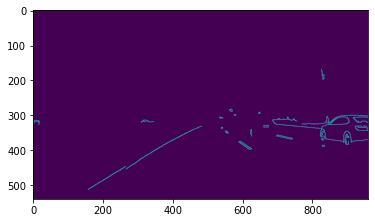

In [35]:
plt.imshow(edge_img)

### Applying ROI selection
The restriction of the image to an ROI located in front of the car will set the maximum detection distance of the road lines. 

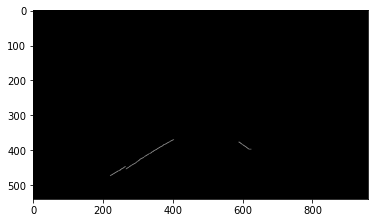

In [36]:
BL = (100,                         edge_img.shape[0] - 80) # bottom left
BR = (edge_img.shape[1] - 100,     edge_img.shape[0])
TR = (int(edge_img.shape[1] / 2 + 100), int(edge_img.shape[0] / 2 + 100))
TL = (int(edge_img.shape[1] / 2 - 100), int(edge_img.shape[0] / 2 + 100))
ROI_vertices = np.array([[BL, BR, TR, TL]])
masked_img = get_img_ROI(edge_img, ROI_vertices)
# At this point, we will ignore the small lines
# Those will be filtered out later

# test result
plt.imshow(masked_img, cmap = 'gray')

### Line detection using probabilistic Hough transform

In [37]:
# Define the Hough transform parameters
rho_reso_px = 1 # distance resolution in pixels of the Hough grid
theta_reso_rad = np.pi/180 # angular resolution in radians of the Hough grid

@interact(hough_vote_threshold = 30, min_line_length = 10, max_line_gap = 100) 
def line_detection(hough_vote_threshold, min_line_length, max_line_gap):
    line_img = hough_lines(masked_img, rho_reso_px, theta_reso_rad, hough_vote_threshold, min_line_length, max_line_gap, y_min = TR[1], y_max = BR[1])
    plt.imshow(line_img)

interactive(children=(IntSlider(value=30, description='hough_vote_threshold', max=90, min=-30), IntSlider(valu…

Observations: 
* The minimum line length must be increased to filter out small lines. 
* The maximum line gap must be as high as possible to connect dashed lines 

Values found for the test_images/solidWhiteCurve.jpg image: 
* hough_vote_threshold = 30
* min_line_length = 10
* max_line_gap = 100
Values found after confronting again to solidYellowCurve.jpg:
* hough_vote_threshold = 30
* min_line_length = 30 --> remove small bits of lane on the right
* max_line_gap = 130 --> increase resulting line length by detecting contiguous segments

In [38]:
# Produce line image with the final parameters
hough_vote_threshold = 30
min_line_length = 10
max_line_gap = 100

aggreg_line_img = hough_lines(masked_img,
                              rho_reso_px,
                              theta_reso_rad,
                              hough_vote_threshold,
                              min_line_length,
                              max_line_gap,
                              y_min = TL[1],
                              y_max = src_img.shape[0])

## Draw the lines on the edge image

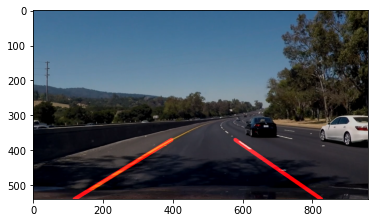

In [39]:
final_img = weighted_img(aggreg_line_img, src_img)
plt.imshow(final_img)
plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    gray_img = grayscale(image)

    kernel_size = 5
    blur_gray_img = gaussian_blur(gray_img, kernel_size)

    #     low_threshold = 50
    #     high_threshold = 150
    low_threshold = 100
    high_threshold = 400
    edge_img = cv2.Canny(blur_gray_img, low_threshold, high_threshold)

    BL = (100,                         edge_img.shape[0] - 80) # bottom left
    BR = (edge_img.shape[1] - 100,     edge_img.shape[0])
    TR = (int(edge_img.shape[1] / 2 + 100), int(edge_img.shape[0] / 2 + 100))
    TL = (int(edge_img.shape[1] / 2 - 100), int(edge_img.shape[0] / 2 + 100))
    ROI_vertices = np.array([[BL, BR, TR, TL]])
    masked_img = get_img_ROI(edge_img, ROI_vertices)
    # At this point, we will ignore the small lines
    # Those will be filtered out later

    # debug
    # plt.imshow(masked_img)

    # Define the Hough transform parameters
    rho_reso_px = 1 # distance resolution in pixels of the Hough grid
    theta_reso_rad = np.pi/180 # angular resolution in radians of the Hough grid

    # Produce line image with the final parameters
    hough_vote_threshold = 30
    min_line_length = 30
    max_line_gap = 110

    aggreg_line_img = hough_lines(masked_img,
                                  rho_reso_px,
                                  theta_reso_rad,
                                  hough_vote_threshold,
                                  min_line_length,
                                  max_line_gap,
                                  y_min = TL[1],
                                  y_max = image.shape[0]-1)

    # Create a "color" binary image to combine with line image
    final_img = weighted_img(aggreg_line_img, image)

    return final_img

Let's try the one with the solid white lane on the right first ...

In [49]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|▌                                                                    | 2/221 [00:00<00:11, 18.74it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4




t:  62%|███████████████████████████████████████▋                        | 137/221 [25:53:17<00:01, 43.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 6.28 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [54]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|▏                                                                    | 2/681 [00:00<00:39, 17.26it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4




t:  87%|██████████████████████████████████████████████████████████▌        | 595/681 [00:17<00:02, 33.63it/s, now=None]


t:  62%|███████████████████████████████████████▋                        | 137/221 [25:54:24<00:01, 43.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 20.5 s


In [56]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [58]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   1%|▌                                                                    | 2/251 [00:00<00:12, 19.95it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4




t:  62%|███████████████████████████████████████▋                        | 137/221 [25:55:20<00:01, 43.63it/s, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
Wall time: 15 s


In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Conclusion
I noticed that there was a slight difference in the results between the code run in Jupyter and on Pycharm. I attached it here for reference. Overall, the challenge recording features the following difficulties:
* Small bits of lines between the dashed lines of the right line
* Flickering of the image (+ blank image?)
* Reflections on the windshield
* Impurities on the road in between the lines
* Variations of brightness
* Variation on the color of the road

The method draw_lane_lines() is an attempt at overcoming those issues, although not correcting them perfectly. The edge cases bring a number of numerical issues that are dealt with in the method, so that it does not crash even if it fails to accomplish its function. This part could be largely improved in production code. 
More time could have been allocated to tweak the different parameters of the pipeline to cope with the different images (i.e. the "challenge" parameters are not usable for the Yellow line challenge). Therefore, a thorough investigation and proper optimization of the different parameters could be required to cover a wider range of cases and conditions. 